<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-01-tree-based-models-bagging-grf-survival-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.1 Survival Forest

A **Survival Forest** is a specialized random forest model designed for analyzing right-censored survival data, estimating conditional survival functions, and supporting causal inference with survival outcomes. It extends the generalized random forest framework to handle survival analysis tasks, such as estimating the probability of survival past a given time point conditional on covariates, $(t, x) = P(T > t | X = x)$.

## Overview

Survival Forests extend random forests to estimate survival probabilities, hazard functions, or cumulative hazard functions for censored data. They:

- `Handle right-censored data` (e.g., patients lost to follow-up).
- `Predict` survival curves or risk scores for individuals.
- Support `heterogeneous effect`s and non-linear relationships.
- Use `ensemble tree-based` methods to improve robustness.




### Key Features

-   `Honest Estimation`: Reduces bias by separating data for splits and leaf estimates.[ ](https://rdrr.io/cran/grf/man/grf-package.html)
-   `Causal Survival Analysis`: Supports estimating heterogeneous treatment effects for survival outcomes using `causal_survival_forest()`.[ ](https://grf-labs.github.io/grf/)
-   `Missing Data`: Handles missing covariates via imputation methods.
-   `Statistical Inference`: Provides confidence intervals for survival function estimates and treatment effects.[ ](https://rdrr.io/cran/grf/man/grf-package.html)
-   `Non-Parametric`: Makes no distributional assumptions, suitable for complex survival data.


### How It Works

1.  Input Data:

  -   A feature matrix $X$ (covariates).
  -   A vector of observed times $Y$ (minimum of survival time and censoring time).
  -   A vector of censoring indicators $D$ (1 if the event is observed, 0 if censored).
  -   Parameters like `num.trees`, `honesty`, and `min.node.size`.

2.  Tree Construction

  -   Trees are grown using bootstrap samples and random feature selection, as in standard random forests.
  -   Splits are chosen to maximize heterogeneity in the survival function, using a criterion tailored for survival data (e.g., log-rank or related statistics).
  -   If `honesty = TRUE`, data is split into two subsets: one for building the tree structure and another for estimating survival functions in the leaves.

3.  Prediction

   -   For a new data point $x$, the forest estimates $S(t, x)$ by averaging survival function estimates across trees, based on the Kaplan-Meier estimator or similar methods within each leaf.

4.  Output

  -   Conditional survival function estimates for specified time points.
  -   Supports causal survival analysis (e.g., via `causal_survival_forest()` for heterogeneous treatment effects with censored data).
  -   Provides confidence intervals and variable importance measures.

### Use Case

-   Estimating conditional survival probabilities (e.g., patient survival given clinical features).
-   Causal inference with survival outcomes (e.g., treatment effects in clinical trials with censoring).


## Survival Forest with  in Python

We will creat a custom `survival_forest()` function provides a Python-native, flexible, and feature-rich alternative to R’s `grf::survival_forest`, addressing gaps in existing libraries while maintaining compatibility with survival analysis workflows. This code will trains a forest for right-censored surival data that can be used to estimate the conditional survival function $S(t, x) = P[T > t | X = x]$, handle right-censored data, and support key features like Kaplan-Meier predictions, variable importance, and optional parameters for tree construction. Since EconML does not natively support survival analysis with censoring, scikit-survival is the best choice. The function will mimic the interface and functionality of `grf::survival_forest` as closely as possible, with notes on differences (e.g., lack of native honesty support).


1. **Mimic R’s `grf::survival_forest`**: The R `grf` package’s `survival_forest` is a standard for survival analysis with right-censored data, offering features like Kaplan-Meier estimation, honesty, and variable importance. This Python function bridges the gap for Python users, replicating key functionalities not fully available in existing libraries like **EconML** or **scikit-survival**.

2. **Address Limitations in `scikit-survival`**: While `scikit-survival`’s `RandomSurvivalForest` supports survival analysis, it lacks native support for advanced features like honesty (separating data for tree construction and prediction) and exact sample fraction control. The custom function implements these (e.g., manual honesty splitting) to align with `grf`.

3. **Flexibility and Customization**: The custom function allows tailoring parameters (e.g., `num_trees`, `mtry`, `prediction_type`) and outputs (e.g., survival curves, variable importance) to match specific research needs, improving usability for tasks like estimating \( S(t, x) = P[T > t | X = x] \).

4. **Avoid Dependency on R**: Instead of relying on R’s `grf` via `rpy2`, a native Python implementation ensures seamless integration into Python workflows, especially in environments like Google Colab.

5. **Enhanced Output**: The function returns a structured dictionary with the model, event times, OOB predictions, and variable importance, making it easier to interpret and visualize results compared to raw `scikit-survival` outputs.

We will creat  custom `survival_forest()` function provides a Python-native, flexible, and feature-rich alternative to R’s `grf::survival_forest`, addressing gaps in existing libraries while maintaining compatibility with survival analysis workflows.




In [ ]:
!pip install econml
!pip install sckit-survival

In [51]:
# Import libraries
import numpy as np
import pandas as pd
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import Optional, List

# Define the survival_forest function
def survival_forest(
    X: np.ndarray,
    Y: np.ndarray,
    D: np.ndarray,
    num_trees: int = 1000,
    sample_fraction: float = 0.5,
    mtry: Optional[int] = None,
    min_node_size: int = 15,
    honesty: bool = True,
    honesty_fraction: float = 0.5,
    prediction_type: str = "Kaplan-Meier",
    compute_oob_predictions: bool = True,
    seed: Optional[int] = None,
    feature_names: Optional[List[str]] = None
) -> dict:
    """
    Train a survival forest for right-censored survival data to estimate S(t, x) = P[T > t | X = x].
    """
    # Input validation
    if not isinstance(X, np.ndarray) or X.ndim != 2:
        raise ValueError("X must be a 2D numpy array")
    if not isinstance(Y, np.ndarray) or not isinstance(D, np.ndarray):
        raise ValueError("Y and D must be numpy arrays")
    if len(X) != len(Y) or len(Y) != len(D):
        raise ValueError("X, Y, and D must have the same length")
    if not np.all(Y > 0):
        raise ValueError("Survival times (Y) must be positive")
    if not np.all(np.isin(D, [0, 1])):
        raise ValueError("Event indicators (D) must be 0 (censored) or 1 (event)")
    if sample_fraction <= 0 or sample_fraction > 1:
        raise ValueError("sample_fraction must be in (0, 1]")
    if prediction_type not in ["Kaplan-Meier", "Nelson-Aalen"]:
        raise ValueError("prediction_type must be 'Kaplan-Meier' or 'Nelson-Aalen'")

    # Set random seed
    if seed is not None:
        np.random.seed(seed)

    # Prepare structured survival data
    y_struct = Surv.from_arrays(event=D, time=Y)

    # Handle mtry
    n_features = X.shape[1]
    if mtry is None:
        mtry = min(int(np.sqrt(n_features) + 20), n_features)

    # Handle honesty
    if honesty:
        n = len(X)
        train_idx = np.random.choice(n, size=int(honesty_fraction * n), replace=False)
        pred_idx = np.setdiff1d(np.arange(n), train_idx)
        X_train, y_train = X[train_idx], y_struct[train_idx]
        X_pred, y_pred = X[pred_idx], y_struct[pred_idx]
    else:
        X_train, y_train = X, y_struct
        X_pred, y_pred = X, y_struct

    # Initialize and train RandomSurvivalForest
    from sksurv.ensemble import RandomSurvivalForest
    rsf = RandomSurvivalForest(
        n_estimators=num_trees,
        max_features=mtry,
        min_samples_split=min_node_size,
        min_samples_leaf=min_node_size // 2,
        bootstrap=True,
        random_state=seed
    )
    rsf.fit(X_train, y_train)

    # Compute event times from training data (unique times where events occurred)
    event_times = np.sort(np.unique(y_train['time'][y_train['event']]))

    # Compute predictions
    if prediction_type == "Kaplan-Meier":
        predict_fn = rsf.predict_survival_function
    else:
        predict_fn = rsf.predict_cumulative_hazard_function

    # OOB predictions (approximated)
    oob_predictions = None
    if compute_oob_predictions:
        oob_predictions = predict_fn(X_pred)

    # Variable importance (not supported in scikit-survival, set to None)
    variable_importance = None
    if feature_names is not None:
        print("Warning: Variable importance not supported in scikit-survival's RandomSurvivalForest.")
        variable_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': [np.nan] * len(feature_names)  # Placeholder
        })

    return {
        'model': rsf,
        'event_times': event_times,
        'oob_predictions': oob_predictions,
        'variable_importance': variable_importance
    }

### Prepare the Data

Fields in y: ('Status', 'Survival_in_days')
NAs in time: 0
NAs in status: 0
First few rows of lung dataset:
    Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment   time  status  
0            no  standard   72.0    True  
1           yes  standard  411.0    True  
2            no  standard  228.0    True  
3           yes  standard  126.0    True  
4           yes  standard  118.0    True  
Rows after removing NAs: 137
Number of events (D=True):
True     128
False      9
Name: count, dtype: int64
Summary of event times where event observed:
count    128.000000
mean     122.125000
std      162.610156
min  

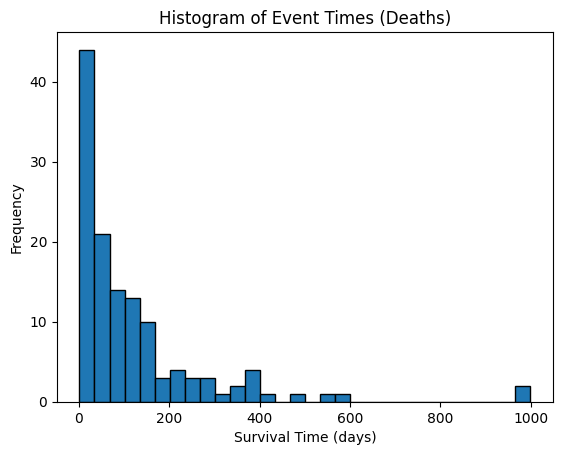

Using horizon = 999.0


In [52]:
# Load the veterans_lung_cancer dataset
X, y = load_veterans_lung_cancer()

# Inspect the field names of y
print("Fields in y:", y.dtype.names)  # Should show ('Status', 'Survival_in_days')

# Convert to DataFrame for easier manipulation
lung = X.copy()
lung['time'] = y['Survival_in_days']  # Correct field name
lung['status'] = y['Status']  # Keep as boolean (True=event, False=censored)

# Check for NAs in key variables
print("NAs in time:", lung['time'].isna().sum())
print("NAs in status:", lung['status'].isna().sum())
print("First few rows of lung dataset:\n", lung.head())

# --- Prepare the Data ---
# Choose covariates (limited to available features in veterans_lung_cancer)
covar_names = ['Age_in_years', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy']

# Encode categorical variable 'Prior_therapy'
le = LabelEncoder()
lung['Prior_therapy'] = le.fit_transform(lung['Prior_therapy'])  # Convert 'yes'/'no' to 0/1

# Drop rows with missing values
lung2 = lung[['time', 'status', 'Treatment'] + covar_names].dropna()
print("Rows after removing NAs:", len(lung2))

# Prepare variables for survival forest
Y = lung2['time'].values  # Survival times
D = lung2['status'].values  # Boolean (True=event, False=censored)
W = (lung2['Treatment'] == 'test').astype(int).values  # 1=test, 0=standard
X = lung2[covar_names].values  # Covariates as numpy array
feature_names = covar_names

# Convert D to int for survival_forest
D_int = D.astype(int)

# Check distribution of events and event times
print("Number of events (D=True):")
print(pd.Series(D).value_counts())
print("Summary of event times where event observed:")
print(pd.Series(Y[D]).describe())
plt.hist(Y[D], bins=30, edgecolor='k')
plt.title("Histogram of Event Times (Deaths)")
plt.xlabel("Survival Time (days)")
plt.ylabel("Frequency")
plt.show()

# Find a valid horizon (latest time with at least one event)
event_times = np.sort(np.unique(Y[D]))
last_valid_ht = event_times[-1]
for ht in event_times:
    n_events = np.sum(D & (Y <= ht))
    if n_events > 0:
        last_valid_ht = ht
print("Using horizon =", last_valid_ht)

### Split Data into Training and Test Sets

In [53]:
train_prop = 0.8
n = len(lung2)
train_idx = np.random.choice(n, size=int(train_prop * n), replace=False)
test_idx = np.setdiff1d(np.arange(n), train_idx)

# Training data
X_train = X[train_idx]
Y_train = Y[train_idx]
D_train = D_int[train_idx]  # Use int for survival_forest
W_train = W[train_idx]

# Test data
X_test = X[test_idx]
Y_test = Y[test_idx]
D_test = D[test_idx]  # Use boolean for concordance
W_test = W[test_idx]

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Column names of X_train:", covar_names)

Training set size: 109
Test set size: 28
Column names of X_train: ['Age_in_years', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy']


### Train the Survival Forest

Survival forest is trained using the `survival_forest()` function, which estimates the conditional survival function based on the training data.

In [54]:
# --- Train the Survival Forest ---
result = survival_forest(
    X=X_train,
    Y=Y_train,
    D=D_train,
    num_trees=1000,
    sample_fraction=0.5,
    mtry=min(int(np.sqrt(X_train.shape[1]) + 20), X_train.shape[1]),
    min_node_size=15,
    honesty=True,
    honesty_fraction=0.5,
    prediction_type="Kaplan-Meier",
    compute_oob_predictions=True,
    seed=123,
    feature_names=feature_names
)

# Print model summary
print(result['model'])

RandomSurvivalForest(max_features=4, min_samples_leaf=7, min_samples_split=15,
                     n_estimators=1000, random_state=123)


### Evaluate the Survival Forest

In [55]:
# Predict on test set
surv_fns_test = result['model'].predict_survival_function(X_test)
time_points = result['event_times']

# Evaluate using concordance (using boolean D_test)
risk_scores = result['model'].predict(X_test)  # Risk scores
concordance = concordance_index_censored(D_test, Y_test, risk_scores)[0]
print("Test Set Concordance:", concordance)

Test Set Concordance: 0.655786350148368


### Visualize Survival Curves

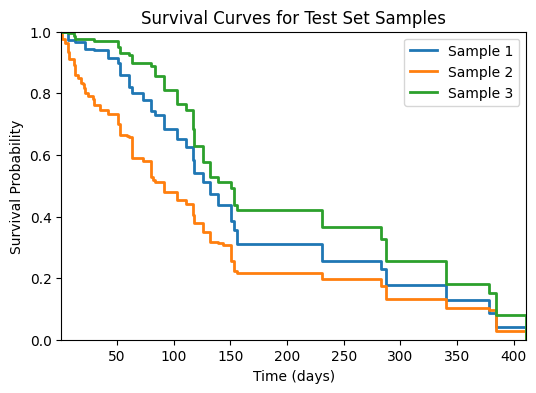

In [56]:
plt.figure(figsize=(6, 4))
for i, surv_fn in enumerate(surv_fns_test[:min(3, len(X_test))]):
    # Ensure surv_fn is evaluated at the correct time points
    surv_values = surv_fn(time_points)  # Evaluate survival function at time_points
    plt.step(time_points, surv_values, where="post", label=f"Sample {i+1}", linewidth=2)
plt.title("Survival Curves for Test Set Samples")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.xlim(min(time_points), max(time_points))
plt.ylim(0, 1)
plt.legend()
plt.show()


### Compute Median Survival Time

In [57]:
# Compute Median Survival Time
median_survival = []
for surv_fn in surv_fns_test:
    surv_values = surv_fn(time_points)  # Evaluate at time_points
    idx = np.where(surv_values <= 0.5)[0]
    median_time = time_points[idx[0]] if len(idx) > 0 else np.nan
    median_survival.append(median_time)
print("Median survival times for test set (first 5 samples):", median_survival[:5])

Median survival times for test set (first 5 samples): [np.float64(132.0), np.float64(92.0), np.float64(151.0), np.float64(151.0), np.float64(20.0)]


### Variable Importance

The code below calculates permutation importance for your survival forest model. It measures how much shuffling a feature's values affects the model's prediction performance (using the concordance index or C-Index) to determine its importance. The results are stored and displayed in a table.

`concordance_index_censored` is a function from the `sksurv.metrics `module that calculates the concordance index (C-index) for survival data that may contain censored observations.

In [58]:
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
import pandas as pd

# Define a wrapper function for concordance_index_censored
def concordance_scorer(estimator, X, y):
    """
    Wrapper for concordance_index_censored to be used with permutation_importance.
    """
    # y is a structured array with 'event' and 'time' fields
    event_indicator = y['event']
    event_time = y['time']
    # Predict risk scores (lower score = higher survival)
    # sksurv's predict gives risk scores by default (higher score = lower survival)
    # We need to negate or invert the prediction for concordance
    risk_scores = estimator.predict(X)
    # concordance_index_censored expects estimate where higher values mean higher risk
    # sksurv.predict gives higher values for lower survival, so we can use it directly as a risk score
    cindex, _, _, _, _ = concordance_index_censored(event_indicator, event_time, risk_scores)
    return cindex

# Calculate permutation importance
# Note: Permutation importance can be computationally expensive
result_importance = permutation_importance(
    result['model'],
    X_test,
    Surv.from_arrays(event=D_test, time=Y_test), # Pass y as a structured array
    scoring=concordance_scorer, # Use the wrapper function
    n_repeats=10,  # Number of times to permute a feature
    random_state=123,
    n_jobs=-1  # Use all available CPU cores
)

# Store the importance results
importance_mean = result_importance.importances_mean
importance_std = result_importance.importances_std

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': importance_mean,
    'Importance_Std': importance_std
})

# Sort by importance
importance_df = importance_df.sort_values('Importance_Mean', ascending=False)

# Print the importance scores
print("Permutation Importance:")
print(importance_df)

Permutation Importance:
                 Feature  Importance_Mean  Importance_Std
1        Karnofsky_score         0.193323        0.055980
0           Age_in_years        -0.013798        0.004787
3          Prior_therapy        -0.020623        0.019040
2  Months_from_Diagnosis        -0.030267        0.020561


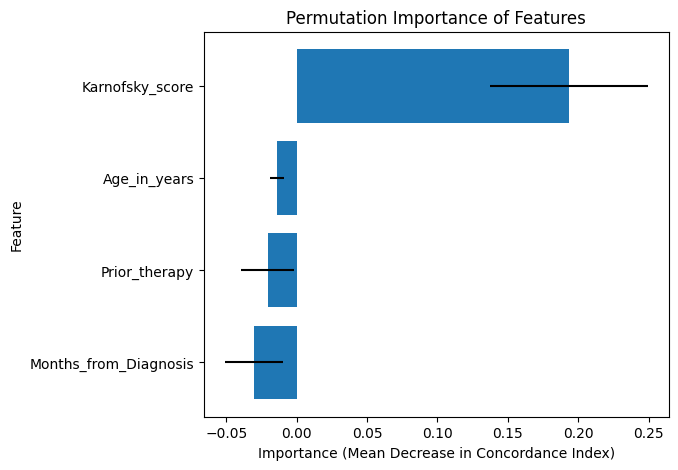

In [59]:
# Plot the permutation importance using matplotlib directly
plt.figure(figsize=(6, 5))
plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], xerr=importance_df['Importance_Std'])
plt.title("Permutation Importance of Features")
plt.xlabel("Importance (Mean Decrease in Concordance Index)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Invert y-axis to have the most important feature on top
plt.show()


## Summary and Conclusion

This notebook explores the concept and implementation of a Survival Forest, a machine learning model tailored for analyzing right-censored survival data. It explains how Survival Forests extend standard random forests to handle survival outcomes, providing insights into key features like handling censored data, predicting survival curves, and supporting causal inference. The notebook highlights the motivation for creating a custom Python survival_forest() function to mimic the functionality of R's grf::survival_forest and address limitations in existing Python libraries like scikit-survival.

The practical implementation uses the sksurv library to build the Survival Forest. The notebook demonstrates the process with the veterans lung cancer dataset, including data loading, preprocessing (handling categorical variables and missing data), splitting data into training and testing sets, training the survival_forest() function, and evaluating the model's performance using the concordance index. It also shows how to visualize survival curves for individual test samples and compute median survival times. Finally, it calculates and visualizes the permutation importance of features to understand their impact on the model's predictions.

The notebook successfully demonstrates how to implement and utilize a Survival Forest in Python for analyzing right-censored survival data. By creating a custom function and leveraging sksurv, it provides a flexible approach to estimate conditional survival functions and assess feature importance. While acknowledging the current limitations of scikit-survival regarding native honesty support and direct variable importance calculation within the model object, the notebook showcases how permutation importance can be used as an alternative for understanding feature contributions. The results, including the concordance index and feature importance plot, provide valuable insights into the factors influencing survival in the veterans lung cancer dataset. This approach offers a powerful tool for researchers and practitioners working with survival data in Python.


## References

1.  Cui, Yifan, Michael R. Kosorok, Erik Sverdrup, Stefan Wager, and Ruoqing Zhu. "Estimating Heterogeneous Treatment Effects with Right-Censored Data via Causal Survival Forests." Journal of the Royal Statistical Society: Series B, 85(2), 2023.

2.  Ishwaran, Hemant, Udaya B. Kogalur, Eugene H. Blackstone, and Michael S. Lauer. "Random survival forests." The Annals of Applied Statistics 2.3 (2008): 841-860.

3.  [Survival forest](hhttps://grf-labs.github.io/grf/reference/survival_forest.html#arguments)
